In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math

In [2]:
# Util for showing omages
def show(img, size=75):
    plt.figure(figsize = (size,size))
    
    if len(img.shape) == 2: # if grayscale, set cmap
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    else: # if 3 channels, change from BGR to RGB
        plt.imshow(img[...,::-1])
        
    plt.show()

# Block Matching

In [3]:
from joblib import Parallel, delayed

def SAD(matA, matB):
  return np.sum(np.abs(matA - matB))

def SSD(matA, matB):
  return np.sum(np.square(matA - matB))

def get_row_matches(row, imgL, imgR, window, matching_fn):
  _, width, _ = imgL.shape
  # Window offset
  offset = int(window/2)
  result = []
  for colLeft in range(offset, width-offset):
    template = imgL[row-offset:row+offset +
                    1, colLeft-offset:colLeft+offset+1, :]

    bestMatchCol = -1
    bestMatchVal = math.inf

    for colRight in range(offset, width-offset):
      match = imgR[row-offset:row+offset+1,
                   colRight-offset:colRight+offset+1, :]
      matchVal = matching_fn(template, match)

      if matchVal < bestMatchVal:
        bestMatchCol = colRight
        bestMatchVal = matchVal
    
    # Append disparity
    if bestMatchCol != -1: 
      result.append(np.abs(colLeft - bestMatchCol))
    else: 
      result.append(0)
  return result


def get_block_matches(imgL, imgR, window, matching_fn):
  height, _, _ = imgL.shape
  offset = int(window/2)

  results = Parallel(n_jobs=10)(delayed(get_row_matches)(i, imgL, imgR, window,
                                              matching_fn) for i in range(offset, height-offset))
  return np.array(results)

In [4]:
imgL = cv.imread("./l1.png")
imgR = cv.imread("./r1.png")

for window in [3, 5, 9]:
  print("Window size: ", window)

  print("Calculating SAD ... ")
  disparity_map = get_block_matches(imgL, imgR, window, SAD)
  cv.imwrite(f"./block_matching/output_{window}_SAD.png", disparity_map)


  print("Calculating SSD ... ")
  disparity_map = get_block_matches(imgL, imgR, window, SSD)
  cv.imwrite(f"./block_matching/output_{window}_SSD.png", disparity_map)

  

Window size:  3
Calculating SAD ... 


KeyboardInterrupt: 

# Dynamic Programming

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

left_image = Image.open('./l1.png').convert('L')  # reading the image as a grayscale
left_image = np.asarray(left_image)

right_image = Image.open('./r1.png').convert('L')  # reading the image as a grayscale
right_image = np.asarray(right_image)


left_image = np.pad(left_image, ((3, 3), (3, 3)), 'constant', constant_values=0) # The padding step for the left image
right_image = np.pad(right_image, ((3, 3), (3, 3)), 'constant', constant_values=0) # The padding step for the right image

height, width = left_image.shape

patch_size = 9
half_size = patch_size // 2
depth = np.zeros(left_image.shape) # The depth map

In [ ]:
for i in range(half_size, height-half_size):
    disparity_space_image = np.zeros((width, width))
    for j in range(half_size, width-half_size):
        right_image_mask = right_image[i-half_size : i+half_size+1, j-half_size : j+half_size+1]  # Patch from the right image
        for k in range(half_size, width-half_size):
            left_image_mask = left_image[i-half_size : i+half_size+1, k-half_size : k+half_size+1]  # Patch from the left image
            disparity_space_image[j, k] = np.sum(abs(right_image_mask - left_image_mask))
    occlusion_cost = 1 * (patch_size**2)
    C = np.zeros((width, width))
    M = np.zeros((width, width))

    for x in range(width):
        C[x, half_size] = x * occlusion_cost
        C[half_size, x] = x * occlusion_cost

    for x in range(half_size+1, width):
        for y in range(half_size+1, width):
            min_1 = C[x-1, y-1] + abs(disparity_space_image[x, y])
            min_2 = C[x-1, y] + occlusion_cost
            min_3 = C[x, y-1] + occlusion_cost
            C[x, y] = min([min_1, min_2, min_3])
            c_min = min([min_1, min_2, min_3])
            if (min_1 == c_min):
                M[x, y] = 1
            elif (min_2 == c_min):
                M[x, y] = 2
            elif (min_3 == c_min):
                M[x, y] = 3
    x = width-half_size-1
    y = width-half_size-1

    while (x != half_size and y != half_size):
        if M[x, y] == 1:
            depth[i, x] = abs(x - y)
            x -= 1
            y -= 1
        elif M[x, y] == 2:
            x -= 1
        elif M[x, y] == 3:
            y -= 1

for x in range(depth.shape[0]):
    for y in range(depth.shape[1]):
        if depth[x, y] == 0:
            for z in range(y, depth.shape[1]):
                if depth[x, z] != 0:
                    depth[x, y] = (depth[x, y-1] + depth[x, z]) // 2
                    break
                else:
                    depth[x, y] = depth[x, y-1]

In [ ]:
plt.imshow(depth, cmap='gray')
plt.axis('off')
plt.show()

In [62]:
def compute_row_correspondence(rowL, rowR, c, sigma, return_dir=False):
    DIAGONAL, UP, LEFT = 0, 1, 2

    dist = (rowL[:, None, :] - rowR) ** 2
    dist = dist.sum(axis=-1) / sigma**2

    width = dist.shape[0]
    dp = np.zeros_like(dist)
    dir = np.zeros_like(dist)
    
    dp[0, 0] = dist[0, 0]
    for i in range(1, width):
        dp[i, 0] = dist[0, 0] + c * i
        dp[0, i] = dist[0, 0] + c * i

        dir[i, 0] = UP
        dir[0, i] = LEFT


    for i in range(1, width):
        for j in range(1, width):
            vals = (dp[i-1, j-1] + dist[i, j], dp[i-1, j] + c, dp[i, j-1] + c)
            dp[i][j] = min(vals)
            dir[i][j] = np.argmin(vals)

    i, j = width-1, width-1

    row_disp = np.zeros(width)
    while i > 0 or j > 0:
        if dir[i][j] == DIAGONAL:
            row_disp[i] = np.abs(i - j)
            i -= 1
            j -= 1
        elif dir[i][j] == UP:
            i -= 1
        else:
            j -= 1

    if return_dir:
        return (row_disp, dir)
    else:
        return row_disp



def dp_disparity_map(imgL, imgR, c=1, sigma=2):
    height, width = imgL.shape[:2]
    disparity_map = np.zeros((height, width))

    for row in range(height):
        if (row + 1) % 5 == 0:
            print(row + 1)
        rowL = imgL[row, ...]
        rowR = imgR[row, ...]

        row_disp = compute_row_correspondence(rowL, rowR, c, sigma)
        disparity_map[row] = row_disp

    return disparity_map

In [10]:
imgL = cv.imread('./l1.png')
imgR = cv.imread('./r1.png')

disparity_map = dp_disparity_map(imgL, imgR, 1, 2)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285


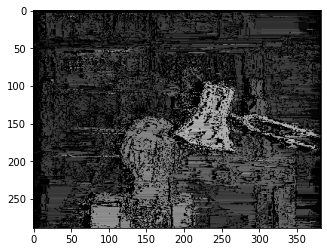

In [11]:
plt.imshow(disparity_map, cmap='gray')

In [63]:
def plot_matches(imgL, imgR, row, c=1, sigma=2, offset=20):
    DIAGONAL, UP, LEFT = 0, 1, 2

    height, width, rest_dims = imgL.shape[0], imgL.shape[1], imgL.shape[2:]

    rowL = imgL[row, ...]
    rowR = imgR[row, ...]

    _, dir = compute_row_correspondence(rowL, rowR, c, sigma, True)

    output = np.zeros((width+offset, width+offset, *rest_dims))
    # left image row
    output[:offset, offset:, ...] = np.tile(rowL, (offset, 1, 1))
    # right image row
    output[offset:, :offset, ...] = np.tile(rowR.reshape(-1, 1, 3), (1, offset, 1))

    i, j = width + offset - 1, width + offset - 1

    while i - offset > 0 or j - offset > 0:
        if dir[i - offset][j - offset] == UP:
            output = cv.line(output, (j, i), (j, i-1), (255, 255, 255), 1)
            i -= 1
        elif dir[i - offset][j - offset] == LEFT:
            output = cv.line(output, (j, i), (j-1, i), (255, 255, 255), 1)
            j -= 1
        else:
            output = cv.line(output, (j, i), (j-1, i-1), (255, 255, 255), 1)
            i -= 1
            j -= 1
    return output

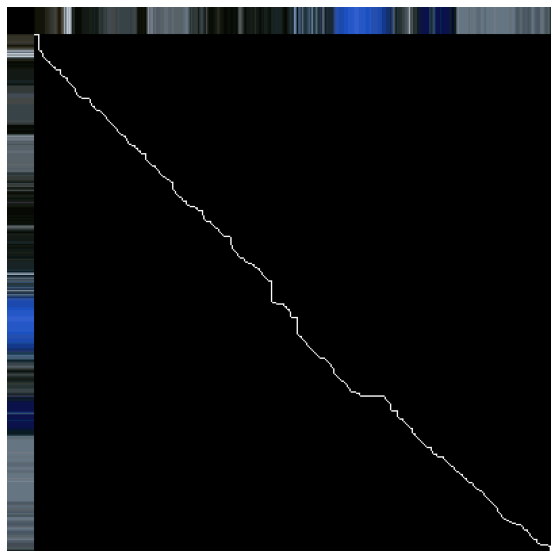

In [67]:
output = plot_matches(imgL, imgR, 120)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(output / 256.0)